<a href="https://colab.research.google.com/github/marcos-code/sigmoidal_datascience/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Churn rate é uma métrica utilizada na gestão de clientes que mostra a taxa de consumidores que uma empresa perdeu em determinado período e o total de receitas envolvidas nesse processo. Seu cálculo considera o número de clientes perdidos na comparação com o total que o negócio possuía no início da relação.

![](https://www.livechatinc.com/wp-content/uploads/2016/04/churn-rate@2x.jpg)

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

Churn também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o churn rate é o que não desejamos.


## Aquisição dos dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [1]:
# Instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [2]:
# Importação das ferramentas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# importar os dados
DATA_PATH =  "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# Visualizando as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Visualizando o o tamanho do dataset
print("Linhas:\t\t{}".format(df.shape[0]))
print("Colunas:\t{}".format(df.shape[1]))

Linhas:		7043
Colunas:	21


# Análise Exploratória dos Dados
Vamos verificar a integridade dos dados.

In [ ]:
print(df.isnull().sum() / df.shape[0])

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [ ]:
# Nomes das features
print("\nNomes das features:\n{}\n".format(df.columns.values))


Nomes das features:
['customerID' 'gender' 'SeniorCitizen' 'Partner' 'Dependents' 'tenure'
 'PhoneService' 'MultipleLines' 'InternetService' 'OnlineSecurity'
 'OnlineBackup' 'DeviceProtection' 'TechSupport' 'StreamingTV'
 'StreamingMovies' 'Contract' 'PaperlessBilling' 'PaymentMethod'
 'MonthlyCharges' 'TotalCharges' 'Churn']



In [ ]:
# Tipos de variáveis por coluna
print("TIpo de variáveis por coluna\n{}".format(df.dtypes))

TIpo de variáveis por coluna
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


In [ ]:
# Valores únicos por coluna
print("Valores únicos (por coluna):\n{}".format(df.nunique()))

Valores únicos (por coluna):
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


Podemos ver que os dados não possui valores ausentes, mas temos que converter a coluna `TotalChanges` para float para então prosseguirmos com as análises.

In [5]:
# Convertendo coluna TotalChanges para float
def converter_str_float(entrada):
  try:
      return float(entrada)
  except ValueError:
      return np.nan

# Criar cópia do dataframe
df_clean = df.copy()

# removendo a coluna costumerID
df_clean.drop("customerID", axis=1, inplace=True)

# Convertendo as strings de TotalChanges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# Verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# Substituir ps dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



Mesmo que o dataset seja composto por variáveis binárias ou categóricas, é possível ver abaixo, que não a indícios da presença de outliers.

In [6]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Vamos checar se existem valores nulos
df_clean.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df_clean.nunique().sort_values()

gender                 2
PaperlessBilling       2
PhoneService           2
Churn                  2
Partner                2
SeniorCitizen          2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
OnlineBackup           3
PaymentMethod          4
tenure                73
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

In [ ]:
cols = ['Churn', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 
        'PhoneService','Contract', 'StreamingMovies','StreamingTV', 'TechSupport', 'OnlineBackup', 
        'OnlineSecurity', 'InternetService', 'MultipleLines', 'DeviceProtection', 'PaymentMethod']
for col in cols:
  print(col, ':', df_clean[col].unique())
      

Churn : ['No' 'Yes']
gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PaperlessBilling : ['Yes' 'No']
PhoneService : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
StreamingMovies : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
OnlineSecurity : ['No' 'Yes' 'No internet service']
InternetService : ['DSL' 'Fiber optic' 'No']
MultipleLines : ['No phone service' 'No' 'Yes']
DeviceProtection : ['No' 'Yes' 'No internet service']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Acima podemos ver que as variáveis são divididas em grupos como:
Sim/Não, Feminino/Masculino, Por ano / Por mês, Dependente sim/não...
Com essas informações podemos ter uma visão melhor de como os serviços sçao oferecidos e até como são as formas de pagamento.


É possível identificar que a classe `No` ocorre com frequência muito superior à classe `Yes`. Isso será considerado na etapa de construção do modelo de machine learning.

Analisando o boxplot para as colunas `MonthlyCharges` e `TotalCharges`, percebemos que sua distribuição não acuspu nenhum plot fora dos limites superior e inferior

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


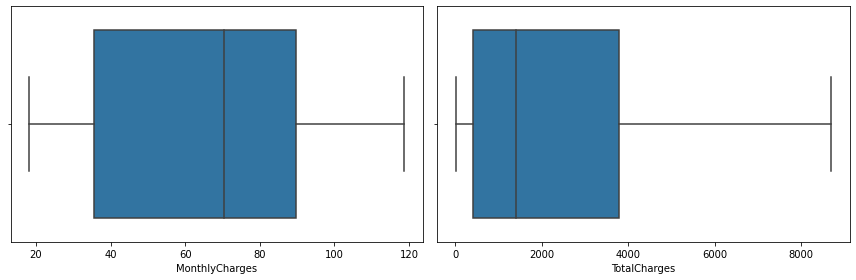

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

Vamos analisar a previsão de churn de alguma variáveis

Para identificar se os nossos dados podem estar com açgum tipo de bias(viés), vamos verificar a contagem de valores para `Male` e `Female`

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


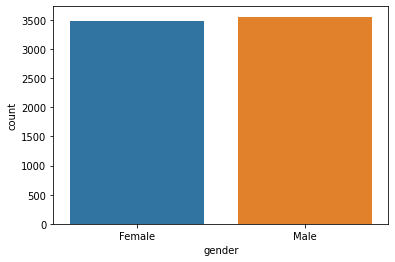

In [10]:
sns.countplot(df.gender)

É possível identificar que a classe `No` ocorre com frequência muito superior à classe `Yes`. Isso será considerado na etapa de construção do modelo de machine learning

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


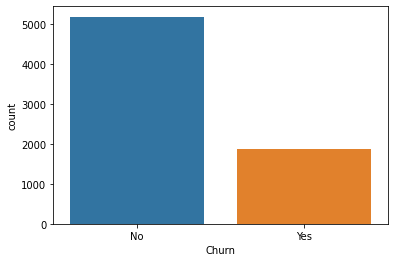

In [11]:
sns.countplot(df_clean.Churn)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

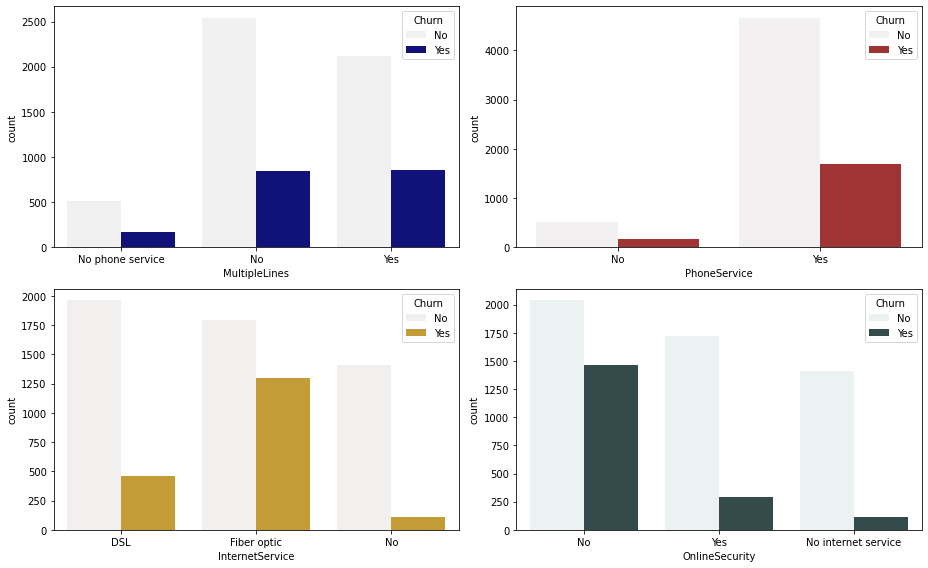

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,8))
sns.countplot('MultipleLines', hue='Churn',data=df_clean,color='darkblue',ax=ax[0,0])
sns.countplot('PhoneService', hue='Churn',data=df_clean,color='firebrick',ax=ax[0,1])
sns.countplot('InternetService', hue='Churn',data=df_clean,color='goldenrod',ax=ax[1,0])
sns.countplot('OnlineSecurity', hue='Churn',data=df_clean,color='darkslategray', ax=ax[1,1])
plt.tight_layout();

* Percebemos que pessoas com fibra ótica são mais propensas a mudarem de serviços do que aquelas que possuem DSL. 
* Pessoas que possuem algum tipo de plano de celular estão mais satisfeitas com aquelas que não tem, vimos que tem alguma que desistem do plano contratado, mas deve ser por conta de algumas promoções que a companhia não disponibiliza com isso ocorre a desistencia
* Alguns possuem multiplos planos podemos ver que grande parte também acabam deixando por conta de melhorias em sua cont.

#Preparar os Dados

Nesta estaoa irei realizar um pré-processamento básico, com afinalidade de construir apenas um modelo base.
As features que continham 2 labels únicos, serão processadas usando o `LabelEncoder`, isso inclui a variável alvo `Churn`.
Depois iremos separar as variáveis numéricas das categóricas. As categóricas serão transformadas em variáveis dummy, para permitir a sua utilização em todos os modelos.

In [13]:
# Pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int','float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# Criar uma cópia do dataframe
df_proc = df_clean.copy()

#Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


# Modelo de Machine Learning

Com o processamento realizado a cima, os dados já poderam ser usado nos modelos de machine learning
Para comparar o desempenho e melhora do modelo, criaremos um baseline simples. Não farei nenhum ajuste no hiperparâmetros e nem será pensado ainda em balenceamento de dados, feature engineering ou feature selection.
Vamos separar os dados que serão utilizados como treino e como teste. Os dados de teste irão ser usados só na última etapa do projeto, para termos uma avaliação.

In [14]:
# separar a feature atrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# Dividir os dados entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)




Vamos para o passo de padronizar e balacear os dados de Churn.


Usarei cross-validation para estimar o erro da baseline e dos modelos iniciais. Para facilitar e melhorar o código, foi criada uma função `val_model`. A métrica utilizada para avaliação será `recall`.


In [15]:
def val_model(X, y, clf, quite=False):
  """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """

  X = np.array(X)
  y = np.array(y)

  pipeline = make_pipeline(StandardScaler(), clf)
  scores = cross_val_score(pipeline, X, y, scoring='recall')

  if quite == False:
    print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

Para o baseline inicial, usarei o Random Forest, sem nenhum tipo de alteração nos parâmetros. Os dados que serão passados são os de treino.


In [16]:
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)


Recall: 0.50 (+/- 0.02)


Uma vez que temos um baseline para comparar se os ajustes melhoram ou pioram o desempenho do modelo, irei realizar o balanceamento dos dados e ver como isso irá impactar.

A técnica escolhida foi Under Sampling, após alguns teste de desempenho das outras. Seguindo recomendações de algumas literaturas, os dados serão padronizados antes de usar essa técnica de balanceamento.

Balanceamento aconteça apenas com os dados de treino. Os dados de teste devem permanecer intocáveis.

In [17]:
# Padronizar os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Aplicar a validação cruzada a vários modelos, com a finalidade de identificar o seu desempenho e escolher o melhor. Serão utilizados somente dados de treino. Os modelos escolhidos são:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM

In [19]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
model = []
recall = []

for clf in [lr, svc, xgb, rf, lgbm]:
  model.append(clf.__class__.__name__)
  recall.append(cross_val_score(clf, X=X_train_rus, y= y_train_rus, cv=5, scoring='recall').mean())

df_ml= pd.DataFrame(recall, model, columns=['recall'])
df_ml

,recall
LogisticRegression,0.798364
SVC,0.789358
XGBClassifier,0.796108
RandomForestClassifier,0.772865
LGBMClassifier,0.775103


Optei pelo XGBoost, praticamente empatado com a Regressão Logística. 

#Otimização dos Hiperparâmetros
O XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definis uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final checar outras taxas de aprendizado.
Logo abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a learning_rate=0.1



In [25]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8148692627090114 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmetros `max_depth` e `min_child_weight`

In [27]:
xgb = XGBClassifier(learning_rate=0.1, n_estimator=50)

param_grid = {
    'max_depth':range(1,8,1),
    'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))


Melhor: 0.8111210862978341 para {'max_depth': 1, 'min_child_weight': 1}


Uma taxa de aprendizado menor, conseguiu melhorar o desempenho do modelo XGBoost, considerando `recall` como sendoa única médtrica de importância.
Agora, treina-se o modelo em cima do dataset de treino completo e verifica- se o desempeho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.


              precision    recall  f1-score   support

           0       0.93      0.58      0.72      1578
           1       0.42      0.87      0.56       535

    accuracy                           0.66      2113
   macro avg       0.67      0.73      0.64      2113
weighted avg       0.80      0.66      0.68      2113

AUC: 0.7289



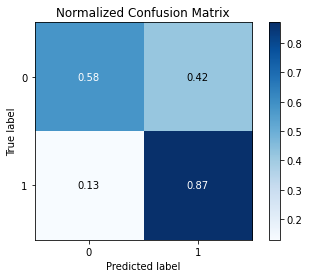

In [29]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001, n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

#fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

#Classification Report
print(classification_report(y_test, y_pred))

#imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

#Plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

#Conclusão
Os dados de teste não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo aquele estimado anteriormente através de otimização nos parâmetros.
O modelo não ficou satisfatório, pois uma métrica de extrema importânncia para o nosso modelo de Churn seria o `recall`, pois nosso objetivo é a diminuição de saídas de clientes do serviço. 
Com esse modelo foi possível vermos alguns padrões no qual busquemos soluções para minimização do churn da empresa.
